# Week 8 Problem 2

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

## Author: John Nguyen
### Primary Reviewer: Apurv Garg 

# Due Date: 6 PM, March 12, 2018

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nose.tools import assert_equal, assert_in, assert_is_not, assert_is_instance, assert_almost_equal
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

# Anomaly Detection using Clustering

Recall that clustering is an unsupervised machine learning task of grouping similar objects. In this assignment, we will detect anomalies by grouping common patterns together using clustering methods which you should've already been familiar with.

We will use [Wholesale Customer dataset](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) which contains spending of wholesale distributors for different types of products.

In [2]:
# Load in the dataset
wholesale_data = pd.read_csv("/home/data_scientist/data/misc/wholesale_data.csv")

# Drop the first two columns which is used for classification
wholesale_data.drop(["Channel", "Region"], axis = 1, inplace = True)

# Preview the data
wholesale_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


Let us view a sample of the data labeled "Fresh" and "Milk". We see that there are several outliers in the plot. With clustering, we will identify the main cluster of wholesalers as well as wholesalers with more unusual  purchasing.

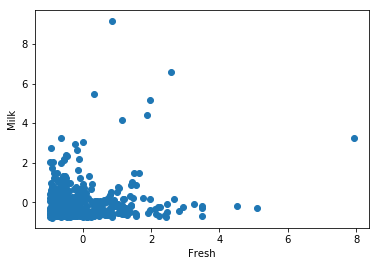

In [3]:
# Obtain the features
data = wholesale_data[wholesale_data.columns]
stscaler = StandardScaler().fit(data)
data = stscaler.transform(data)

plt.scatter(data[:,0], data[:,1])
plt.xlabel("Fresh")
plt.ylabel("Milk");

In [4]:
# This function will help us visualize the results.
def make_plot(df, axs, lbl, c, m):
    
    # Extract Sepal Width for given label
    xx = df[df.Label==lbl][['Fresh']]
    
    # Extract Sepal Length for given label
    yy = df[df.Label==lbl][['Milk']]
    
    # Plot sepal width versus sepal length
    axs.scatter(xx, yy, color=c, marker=m, alpha =0.75, s=60, 
                label='Class={0}'.format(lbl))


## Question 1
 
Use [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to cluster the wholesale customer data. Your function should take into the epsilon threshold specifying the maximum distance between samples as well as the minimum number of samples. Fit the model to the data and output the DBSCAN model instance and cluster labels.

In [9]:
def DBSCAN_model(data, epsilon, num_sample):
    '''    
    Parameters
    ----------
    data: A numpy.ndarray
    epsilon: A float specifying the maximum distance between two samples
    num_sample: A int specifying the minimum number of samples in the neighborhood
    
    Returns
    -------
    model: A sklearn.cluster.DBSCAN instance
    result: A numpy.ndarray of the labels
    '''
    
    # YOUR CODE HERE
    # apply DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=num_sample)
    model = db.fit(data)
    result = model.labels_
    

    return model, result

In [10]:
dbs_model, dbs_labels = DBSCAN_model(data, 0.5, 10)
assert_equal(type(dbs_model), DBSCAN)
assert_equal(type(dbs_labels), np.ndarray)
assert_equal(dbs_model.eps, 0.5)
assert_equal(dbs_model.min_samples, 10)
assert_equal(len(dbs_labels), 440)

dbs_model2, dbs_labels2 = DBSCAN_model(data, 0.25, 15)
assert_equal(type(dbs_model2), DBSCAN)
assert_equal(type(dbs_labels2), np.ndarray)
assert_equal(dbs_model2.eps, 0.25)
assert_equal(dbs_model2.min_samples, 15)
assert_equal(len(dbs_labels2), 440)

In [11]:
dbs_model, dbs_labels = DBSCAN_model(data, 1, 10)

cnt =  Counter(np.sort(dbs_labels))

# Display the results of the clustering
print('DBSCAN Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

DBSCAN Cluster membership.
------------------------------
Noise Cluster :   54 members
Cluster 0     :  386 members


Let us plot the result for "Fresh" and "Milk" to see if the outliers were properly identified.

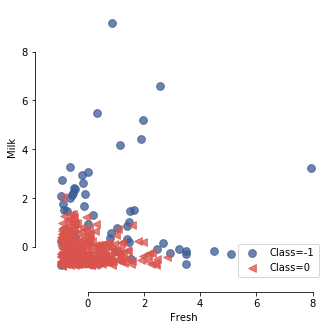

In [12]:
# Create Data Frame from clustered data, rename columns for simplicity
df = pd.DataFrame({'Fresh': data[:,0], 'Milk': data[:,1], 'Label': dbs_labels})

# Create figure
fig, axs = plt.subplots(figsize=(5, 5))

# Define color and markers for plots (assume only four clusters)
ca = [sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red'], 
      sns.xkcd_rgb['medium green'], sns.xkcd_rgb['dusty purple']]
ma = ['o', '<', '>', '^']

# Iterate through clusters
for idx, lbl in enumerate(np.unique(dbs_labels)):
    make_plot(df, axs, lbl, ca[idx], ma[idx])

# Decorate plot
axs.legend(loc=4)
axs.set_xlabel('Fresh')
axs.set_ylabel('Milk')
sns.despine(offset=10, trim=True)

We see from the above plot that the threshold and the minimum number of samples chosen gave very good results. If we change these parameters we would get a totally different results which might not be as good. Let us try other clustering algorithms.

## Question 2

Use [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster the wholesale customer data. Your function should take into the number of clusters as a parameter. Fit the model to the data and output the KMeans model instance and cluster labels. Be sure to set the random state to be 0.

In [13]:
def kmeans_model(data, k):
    '''    
    Parameters
    ----------
    data: A numpy.ndarray
    k: A int specifying the number of clusters
    
    Returns
    -------
    model: A sklearn.cluster.DBSCAN instance
    result: A numpy.ndarray of the labels
    '''

    # YOUR CODE HERE
    model = KMeans(n_clusters=k, random_state=0)
    result = model.fit_predict(data)

    return model, result

In [14]:
kmeans_model1, kmeans_labels = kmeans_model(data, 2)
assert_equal(type(kmeans_model1), KMeans)
assert_equal(type(kmeans_labels), np.ndarray)
assert_equal(kmeans_model1.n_clusters, 2)
assert_equal(kmeans_model1.random_state, 0)
assert_equal(len(kmeans_labels), 440)

kmeans_model2, kmeans_labels2 = kmeans_model(data, 3)
assert_equal(type(kmeans_model2), KMeans)
assert_equal(type(kmeans_labels2), np.ndarray)
assert_equal(kmeans_model2.n_clusters, 3)
assert_equal(kmeans_model2.random_state, 0)
assert_equal(len(kmeans_labels2), 440)

In [15]:
kmeans_model1, kmeans_labels = kmeans_model(data, 2)

cnt =  Counter(np.sort(kmeans_labels))

# Display the results of the clustering
print('k-means Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

k-means Cluster membership.
------------------------------
Cluster 0     :   36 members
Cluster 1     :  404 members


From the above results, we see that k-means seems slightly better than DBSCAN when k=2. Let us also look at the plot to see if this is true.

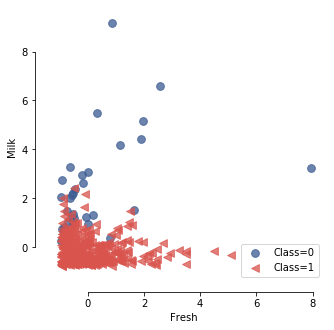

In [16]:
# Create Data Frame from clustered data, rename columns for simplicity
df = pd.DataFrame({'Fresh': data[:,0], 'Milk': data[:,1], 'Label': kmeans_labels})

# Create figure
fig, axs = plt.subplots(figsize=(5, 5))

# Define color and markers for plots (assume only four clusters)
ca = [sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red'], 
      sns.xkcd_rgb['medium green'], sns.xkcd_rgb['dusty purple']]
ma = ['o', '<', '>', '^']

# Iterate through clusters
for idx, lbl in enumerate(np.unique(kmeans_labels)):
    make_plot(df, axs, lbl, ca[idx], ma[idx])

# Decorate plot
axs.legend(loc=4)
axs.set_xlabel('Fresh')
axs.set_ylabel('Milk')
sns.despine(offset=10, trim=True)

Recall from the notebook in Week 7 that we'd used Gaussian Mixture Model (GMM) for the purpose of classification. We can also use GMM for clustering for anomaly detection.

## Question 3

Use [GMM](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the wholesale customer data. Note, this means fitting and making prediction on the same set of data.

Your function should take into the number of components to output the GMM model instance and cluster means. Be sure to set the covariance type to be "full" and random state to be 0. Keep all of the other parameters as the default. Fit the model to the data and return your predictions.

In [21]:
def GMM_model(data, num_components):
    '''    
    Parameters
    ----------
    data: A numpy.ndarray
    num_components: A int specifying the number of components
    
    Returns
    -------
    model: An sklearn.mixture.gaussian_mixture.GaussianMixture instance
    prediction: A numpy.ndarray of predictions
    '''

    # YOUR CODE HERE
    #build model assuming n clusters
    model = GaussianMixture(n_components=num_components, covariance_type='full', random_state=0)
    
    # fit data to assign classes
    model.fit(data)
    
    # obtain the predictions
    result = model.predict(data)

    return model, result

In [22]:
gmm_model1, gmm_predictions = GMM_model(data, 2)
assert_equal(type(gmm_model1), GaussianMixture)
assert_equal(type(gmm_predictions), np.ndarray)
assert_equal(gmm_model1.n_components, 2)
assert_equal(gmm_model1.random_state, 0)
assert_equal(len(gmm_predictions), 440)

gmm_model2, gmm_predictions2 = GMM_model(data, 3)
assert_equal(type(gmm_model2), GaussianMixture)
assert_equal(type(gmm_predictions2), np.ndarray)
assert_equal(gmm_model2.n_components, 3)
assert_equal(gmm_model2.random_state, 0)
assert_equal(len(gmm_predictions2), 440)

In [23]:
gmm_model1, gmm_predictions = GMM_model(data, 2)

cnt =  Counter(np.sort(gmm_predictions))

# Display the results of the clustering
print('GMM Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

GMM Cluster membership.
------------------------------
Cluster 0     :  354 members
Cluster 1     :   86 members


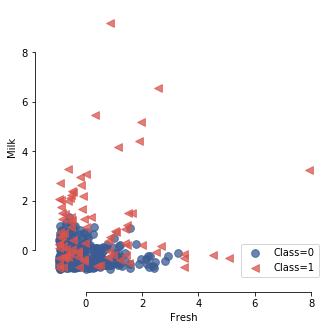

In [24]:
# Create Data Frame from clustered data, rename columns for simplicity
df = pd.DataFrame({'Fresh': data[:,0], 'Milk': data[:,1], 'Label': gmm_predictions})

# Create figure
fig, axs = plt.subplots(figsize=(5, 5))

# Define color and markers for plots (assume only four clusters)
ca = [sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red'], 
      sns.xkcd_rgb['medium green'], sns.xkcd_rgb['dusty purple']]
ma = ['o', '<', '>', '^']

# Iterate through clusters
for idx, lbl in enumerate(np.unique(kmeans_labels)):
    make_plot(df, axs, lbl, ca[idx], ma[idx])

# Decorate plot
axs.legend(loc=4)
axs.set_xlabel('Fresh')
axs.set_ylabel('Milk')
sns.despine(offset=10, trim=True)

As you can see, GMM does not perform very well compared to the other two methods for this particular example.